In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

In [12]:
const λ = 626e-9
const Γ = 2π * 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
;

In [14]:
H_operator = :(
    T * L +
    B_z * (1.4e6 * Zeeman_L0)
)
parameters = @params begin
    T = 478e12
    B_z = 5.
end

# Create basis states
QN_bounds = (L = 0, N = 2)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

# d[1:5, 6:end, 1] ./= sqrt(sum(d[1:5, 6:end, 1].^2))
# d[6:end, 1:5, 1] ./= sqrt(sum(d[6:end, 1:5, 1].^2))
# d[1:5, 6:end, 2] ./= sqrt(sum(d[1:5, 6:end, 2].^2))
# d[6:end, 1:5, 2] ./= sqrt(sum(d[6:end, 1:5, 2].^2))
# d[1:5, 6:end, 3] ./= sqrt(sum(d[1:5, 6:end, 3].^2))
# d[6:end, 1:5, 3] ./= sqrt(sum(d[6:end, 1:5, 3].^2))
# d[1:5,1:5,:] .= 0.0
# d[6:8,6:8,:] .= 0.0
;

In [42]:
# Laser parameters
Δ = +1Γ
s = 1.0

s_orthog = 20

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

k̂ = +x̂; ϵ1 = ϵ_(σ⁰); laser1_orthog = Field(k̂, ϵ1, ω1, s_orthog)
k̂ = -x̂; ϵ2 = ϵ_(σ⁰); laser2_orthog = Field(k̂, ϵ2, ω1, s_orthog)

lasers = [laser1_orthog, laser2_orthog, laser5, laser6]
;

In [43]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [44]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  3.175536 seconds (4.12 M allocations: 404.800 MiB, 3.34% gc time, 94.06% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.0
 -0.3323352264798261

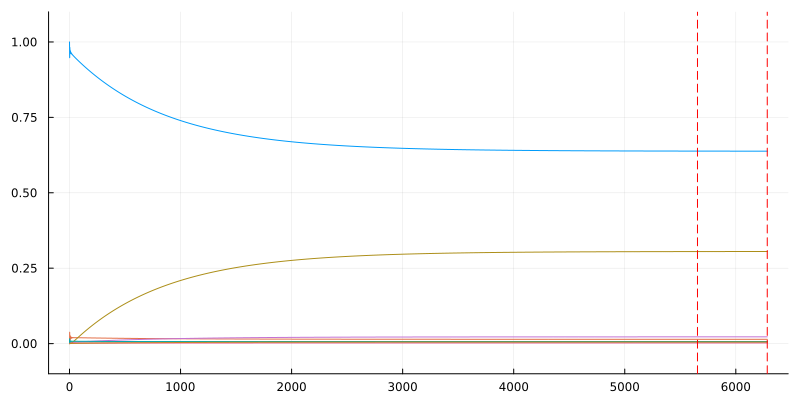

In [45]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

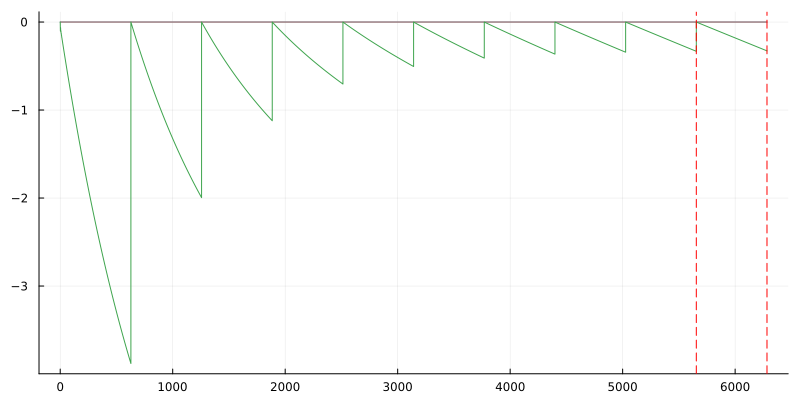

In [46]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [47]:
prob.p.populations

8-element Vector{ComplexF64}:
     0.638432199131005 + 0.0im
  0.014301371511436992 + 0.0im
  0.007080899156124232 + 0.0im
  0.022367805171552478 + 0.0im
    0.3049618082543547 + 0.0im
  0.005709848153135623 + 0.0im
 0.0020949669404347355 + 0.0im
  0.005051101681981738 + 0.0im

In [48]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus magnetic field

In [49]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [78]:
using RectiGrids

freq_res = 1e-2
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:2.0:20.0)
di = 6
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [79]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


 37.726473 seconds (1.51 M allocations: 326.662 MiB)


In [80]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.125785 seconds (77.91 k allocations: 5.304 MiB, 98.71% compilation time)


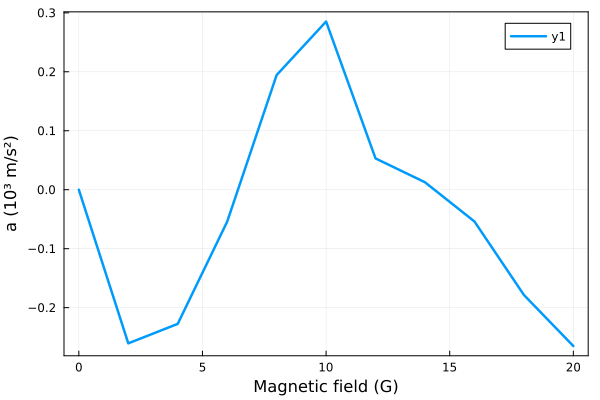

In [81]:
plot(Bs, 1e-3 .* averaged_forces .* (ħ * k * Γ / m),
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

In [82]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.101613 seconds (52.41 k allocations: 3.949 MiB, 98.90% compilation time)


In [83]:
H.states[1]

State{AngularMomentumState_Labelled}(-1.3999999999999996e7, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 2, -2, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0, 2, -1, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0, 2, 0, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0, 2, 1, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 0, 2, 2, (M = -2:2,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

In [86]:
averaged_populations[2]'

8×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.968025232947091
 0.01573263583920605
 0.001807502122906389
 0.002315112086807292
 0.009985143307509195
 0.00141980419539629
 0.0004534442784940105
 0.00026112522259007324

In [87]:
averaged_populations[6]'

8×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.006323426945217028
 0.0018723180345546454
 0.0034310150512626664
 0.014611513710158222
 0.9676775810908327
 0.0018527103050587545
 0.0011102833421240293
 0.003121151520791618